# Segmentación de imágenes con métodos supervisados

En esta práctica se comprenderán los métodos de segmentación de imágenes cuando se cuenta con datos previamente etiquetados por un experto, haciendo uso de técnicas de Aprendizaje Máquina Supervisado. Como datos se utilizarán imágenes de ultrasonido de cerebelo fetal. 

1. Abrir imágenes (ultrasonido, preprocesamiento y mascaras)
2. Extraer datos de entrenamiento y validación
3. Entrenar y validar diferentes clasificadores
4. Segmentar imágenes. 

## 1. Abrir imágenes  

El cerebelo es una región del encéfalo cuya función principal es de integrar las vías sensitivas y las vías motoras. órgano encargado del control de la motricidad, relacionado con ciertas funciones cognitivas como la atención y el procesamiento del lenguaje, la música, el aprendizaje y otros estímulos sensoriales temporales.


<img src="Notebook_Imgs/cerebelo.jpg" alt="Drawing" style="width: 700px;"/>

Se cuenta con una base de datos de imágenes de cerebelo fetal 2D y con la segmentación manual del cerebelo por un experto. 
A su vez se cuenta con imágenes de preprocesamiento.
-	Filtradas: Se realizó un filtrado mediante el filtro Speckle Reduction Anisotropic Difusión (SRAD), el cual hace más homogéneas las regiones y preserva bordes.
-	Ecualización de histograma: Aumenta el contraste entre regiones y resalta bordes
-	Textura: Se cuenta con imágenes que describen la textura de una región calculadas mediante la extracción de descriptores de primer orden (histograma), segundo orden (co-occurrencia y run-length).



In [1]:
import os
import pydicom
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [2]:
def imread(img_filename,img_path):
    
    img = cv2.imread((img_path + img_filename),0)
    
    #Normalizing image
    high = 255
    low = 0
    cmin = img.min()
    cmax = img.max()
    cscale = cmax - cmin
    scale = float(high - low) / cscale
    new_array = (img - cmin) * scale + low
    im = (new_array.clip(low, high) + 0.5).astype(np.uint8)
    
    # resize image
    dim = (128, 128)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    
    return im

In [3]:
path ='Data/Cerebelo/';

img_files = next(os.walk(path + 'Img'))[2]

# Images and masks
imgs = []
masks = []

#Pre-process images
intensity = []

#First order textures
textureDif = []
textureEnt = []
textureKurt = []
textureSkew = []
textureMean = []
textureStd = []

#Second order textures Haralick (co-occurrence)
textureVariance = []
textureContrast = []
textureCorrelation = []
textureEnergy = []
textureHomogeneity = []
textureEntropy = []

#Second order Texture Galloway (Run-length)
textureSRE = []
textureLRE = []
textureGLN = []
textureRLN = []
textureRP = []

#Read all images
for img_file in img_files:
    
    filename = os.path.splitext(img_file)[0]
    
    imgs.append(imread((filename + '.bmp'),(path + 'Img/')))
    masks.append(imread((filename + '_Mask.bmp'),(path + 'Mask/')))
    intensity.append(imread((filename + '_Int.bmp'),(path + 'Intensity/')))
    textureDif.append(imread((filename + '_Dif.bmp'),(path + 'Textures/Histogram/Diferencia/')))
    textureEnt.append(imread((filename + '_Ent.bmp'),(path + 'Textures/Histogram/Entropia/'))) 
    textureKurt.append(imread((filename + '_Kurt.bmp'),(path + 'Textures/Histogram/Kurtosis/')))
    textureSkew.append(imread((filename + '_Skew.bmp'),(path + 'Textures/Histogram/Skewness/')))
    textureMean.append(imread((filename + '_Mean.bmp'),(path + 'Textures/Histogram/Media/')))
    textureStd.append(imread((filename + '_Std.bmp'),(path + 'Textures/Histogram/Std/')))
    textureVariance.append(imread((filename + '_Variance.bmp'),(path + 'Textures/Haralick/Variance/')))
    textureContrast.append(imread((filename + '_Contrast.bmp'),(path + 'Textures/Haralick/Contrast/')))
    textureCorrelation.append(imread((filename + '_Correlation.bmp'),(path + 'Textures/Haralick/Correlation/')))
    textureEnergy.append(imread((filename + '_Energy.bmp'),(path + 'Textures/Haralick/Energy/')))
    textureHomogeneity.append(imread((filename + '_Homogeneity.bmp'),(path + 'Textures/Haralick/Homogeneity/')))
    textureEntropy.append(imread((filename + '_Entropy.bmp'),(path + 'Textures/Haralick/Entropy/')))
    textureSRE.append(imread((filename + '_SRE.bmp'),(path + 'Textures/RunLength/SRE/')))
    textureLRE.append(imread((filename + '_LRE.bmp'),(path + 'Textures/RunLength/LRE/')))
    textureGLN.append(imread((filename + '_GLN.bmp'),(path + 'Textures/RunLength/GLN/')))
    textureRLN.append(imread((filename + '_RLN.bmp'),(path + 'Textures/RunLength/RLN/')))
    textureRP.append(imread((filename + '_RP.bmp'),(path + 'Textures/RunLength/RP/')))
    
imgs = np.array(imgs)
masks = np.array(masks)
intensity = np.array(intensity)
textureDif = np.array(textureDif)
textureEnt = np.array(textureEnt)
textureKurt = np.array(textureKurt)
textureSkew = np.array(textureSkew)
textureMean = np.array(textureMean)
textureStd = np.array(textureStd)
textureVariance = np.array(textureVariance)
textureContrast = np.array(textureContrast)
textureCorrelation = np.array(textureCorrelation)
textureEnergy = np.array(textureEnergy)
textureHomogeneity = np.array(textureHomogeneity)
textureEntropy = np.array(textureEntropy)
textureSRE = np.array(textureSRE)
textureLRE = np.array(textureLRE)
textureGLN = np.array(textureGLN)
textureRLN = np.array(textureRLN)
textureRP = np.array(textureRP)


### Visualizar imagen, mascara y pre-procesamiento

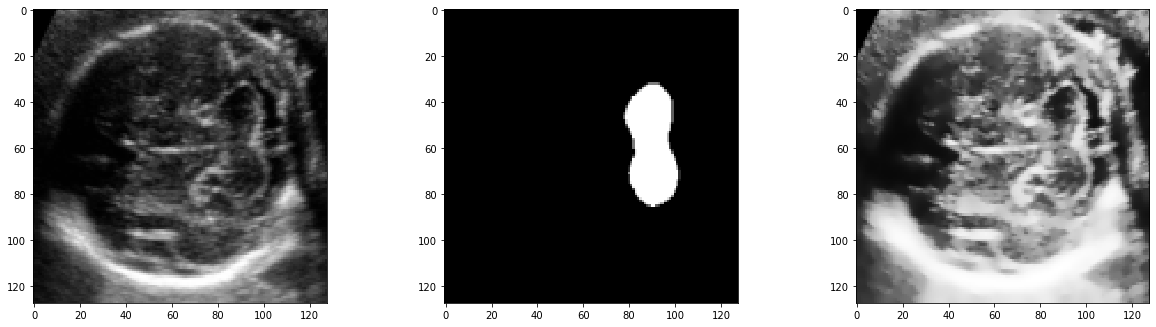

In [4]:
import random

#Get random image from each type

n = random.randint(0,len(imgs))

#Displaying image and mask
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(imgs[n], cmap="gray")

ax = fig.add_subplot(1, 3, 2)
ax.imshow(masks[n], cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(intensity[n], cmap="gray")


Text(0.5, 0.98, 'Run Length')

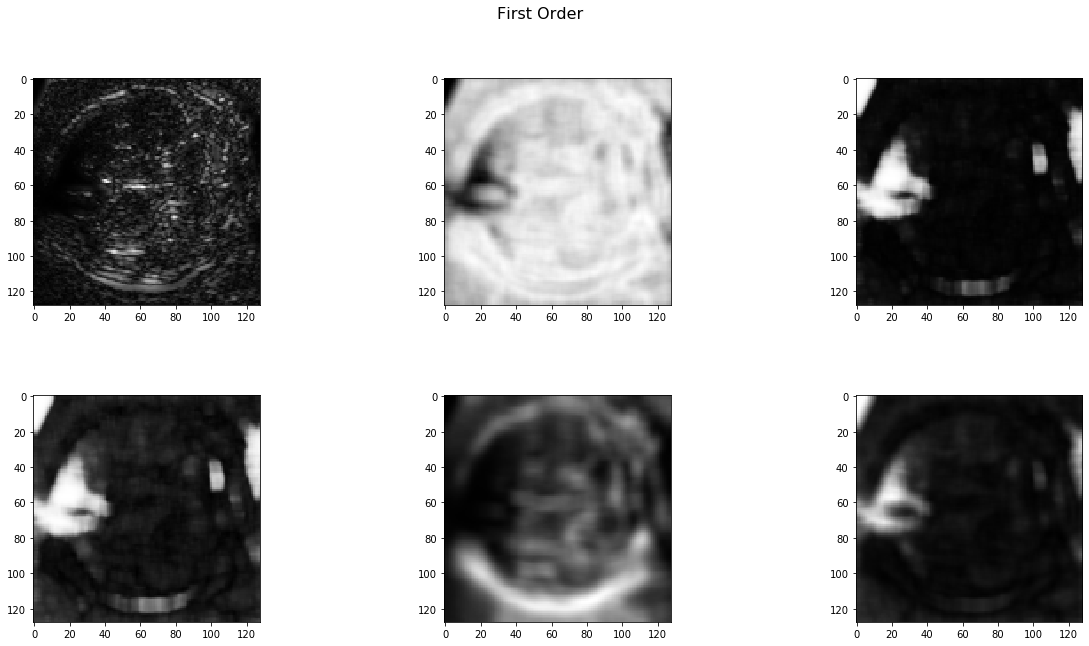

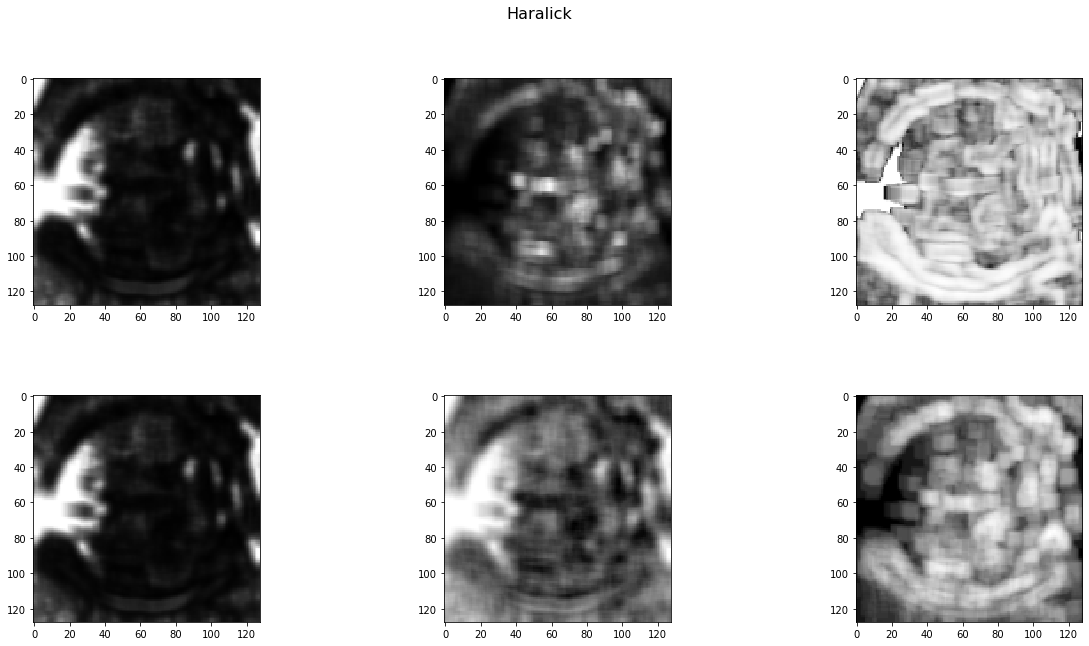

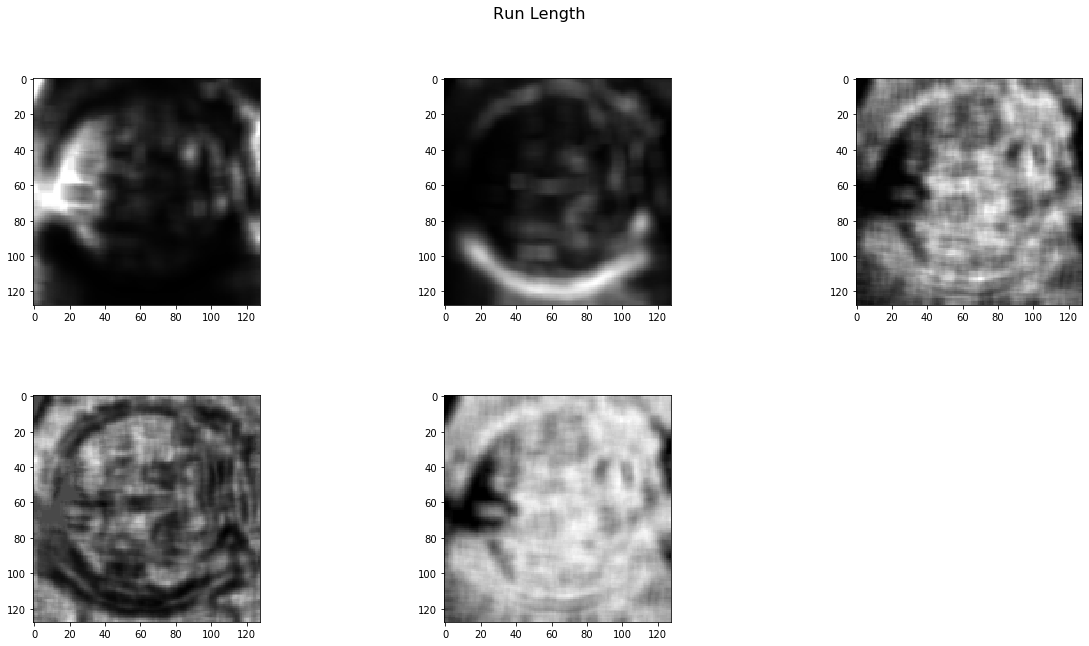

In [5]:
#Displaying first order
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(textureDif[n], cmap="gray")
ax = fig.add_subplot(2, 3, 2)
ax.imshow(textureEnt[n], cmap="gray")
ax = fig.add_subplot(2, 3, 3)
ax.imshow(textureKurt[n], cmap="gray")
ax = fig.add_subplot(2, 3, 4)
ax.imshow(textureSkew[n], cmap="gray")
ax = fig.add_subplot(2, 3, 5)
ax.imshow(textureMean[n], cmap="gray")
ax = fig.add_subplot(2, 3, 6)
ax.imshow(textureStd[n], cmap="gray")
fig.suptitle('First Order', fontsize=16)

#Displaying Haralick
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(textureVariance[n], cmap="gray")
ax = fig.add_subplot(2, 3, 2)
ax.imshow(textureContrast[n], cmap="gray")
ax = fig.add_subplot(2, 3, 3)
ax.imshow(textureCorrelation[n], cmap="gray")
ax = fig.add_subplot(2, 3, 4)
ax.imshow(textureEnergy[n], cmap="gray")
ax = fig.add_subplot(2, 3, 5)
ax.imshow(textureHomogeneity[n], cmap="gray")
ax = fig.add_subplot(2, 3, 6)
ax.imshow(textureEntropy[n], cmap="gray")
fig.suptitle('Haralick', fontsize=16)

#Displaying RunLength
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 3, 1)
ax.imshow(textureSRE[n], cmap="gray")
ax = fig.add_subplot(2, 3, 2)
ax.imshow(textureLRE[n], cmap="gray")
ax = fig.add_subplot(2, 3, 3)
ax.imshow(textureGLN[n], cmap="gray")
ax = fig.add_subplot(2, 3, 4)
ax.imshow(textureRLN[n], cmap="gray")
ax = fig.add_subplot(2, 3, 5)
ax.imshow(textureRP[n], cmap="gray")
fig.suptitle('Run Length', fontsize=16)


## 2. Extraer datos de entrenamiento, validación y prueba

Se separan las imagenes en conjuntos de entrenamiento y de prueba.

In [6]:
import math

train_p = 0.9
    
shuffled_indices = np.arange(len(imgs))
np.random.shuffle(shuffled_indices)
train_idx = shuffled_indices[:math.ceil(len(imgs)*train_p)] 
test_idx = shuffled_indices[math.ceil(len(imgs)*train_p)+1:] 

In [7]:
print("Train images: ")
print(len(train_idx))
print("Test images: ")
print(len(test_idx))

Train images: 
257
Test images: 
27


### Entrenamiento

De cada imágen de entrenamiento se extraeran los niveles de intensidad de gris de pixeles aleatoreos de las imágenes originales, preprocesadas y de textura, así como su posición x,y. Con esto se generara un vector de características para segmentar.

__Separar conjunto de entrnamiento y validación__

Se debe de separar el conjunto de entrenamiento de nuevo, esta vez para entrenar diferentes métodos de machine learning y posteriormente probarlos con el conjunto de validación, para así saber cual es el mejor método de clasificación de pixeles.

In [8]:
# Extract pixels from images

#Percentage of extraction from cerebellum size
p = 0.50

train_data = []

for idx in train_idx:
    
    mask = masks[idx,:,:]

    
    #Extract object characteristics
    [obj_y, obj_x] = np.where(mask!=0)
    n_pixels = math.ceil(len(obj_x)*p)
    
    shuffled_indices = np.arange(len(obj_x))
    np.random.shuffle(shuffled_indices)
    obj_idx = shuffled_indices[:n_pixels] 
    
    for pixel in obj_idx:
        
        obj_charact = [ imgs[idx,obj_x[pixel],obj_y[pixel]], intensity[idx,obj_x[pixel],obj_y[pixel]], 
                        textureDif[idx,obj_x[pixel],obj_y[pixel]], textureEnt[idx,obj_x[pixel],obj_y[pixel]],
                        textureKurt[idx,obj_x[pixel],obj_y[pixel]], textureSkew[idx,obj_x[pixel],obj_y[pixel]],
                        textureMean[idx,obj_x[pixel],obj_y[pixel]], textureStd[idx,obj_x[pixel],obj_y[pixel]],
                        textureVariance[idx,obj_x[pixel],obj_y[pixel]], textureContrast[idx,obj_x[pixel],obj_y[pixel]],
                        textureCorrelation[idx,obj_x[pixel],obj_y[pixel]], textureEnergy[idx,obj_x[pixel],obj_y[pixel]],
                        textureHomogeneity[idx,obj_x[pixel],obj_y[pixel]], textureEntropy[idx,obj_x[pixel],obj_y[pixel]],
                        textureSRE[idx,obj_x[pixel],obj_y[pixel]], textureLRE[idx,obj_x[pixel],obj_y[pixel]],
                        textureGLN[idx,obj_x[pixel],obj_y[pixel]], textureRLN[idx,obj_x[pixel],obj_y[pixel]],
                        textureRP[idx,obj_x[pixel],obj_y[pixel]], obj_x[pixel], obj_y[pixel], 1 ]
        
        train_data.append(obj_charact)
        
    #Extract background characteristics   
    [bkg_y, bkg_x] = np.where(mask==0)
        
    shuffled_indices = np.arange(len(bkg_x))
    np.random.shuffle(shuffled_indices)
    bkg_idx = shuffled_indices[:n_pixels] 
    
    for pixel in bkg_idx:
        
        bkg_charact = [ imgs[idx,bkg_x[pixel],bkg_y[pixel]], intensity[idx,bkg_x[pixel],bkg_y[pixel]], 
                        textureDif[idx,bkg_x[pixel],bkg_y[pixel]], textureEnt[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureKurt[idx,bkg_x[pixel],bkg_y[pixel]], textureSkew[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureMean[idx,bkg_x[pixel],bkg_y[pixel]], textureStd[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureVariance[idx,bkg_x[pixel],bkg_y[pixel]], textureContrast[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureCorrelation[idx,bkg_x[pixel],bkg_y[pixel]], textureEnergy[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureHomogeneity[idx,bkg_x[pixel],bkg_y[pixel]], textureEntropy[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureSRE[idx,bkg_x[pixel],bkg_y[pixel]], textureLRE[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureGLN[idx,bkg_x[pixel],bkg_y[pixel]], textureRLN[idx,bkg_x[pixel],bkg_y[pixel]],
                        textureRP[idx,bkg_x[pixel],bkg_y[pixel]], bkg_x[pixel], bkg_y[pixel], 0 ]
        
        train_data.append(bkg_charact)

train_data = np.array(train_data)
shuffled_indices = np.arange(len(train_data))
np.random.shuffle(shuffled_indices)
train_data = train_data[shuffled_indices]

print("Train data size: " + str(len(train_data)))

Train data size: 172790


In [9]:
import pandas as pd

print(pd.DataFrame(train_data).head(5))
print(pd.DataFrame(train_data).tail(5))

   0    1   2    3   4    5    6   7    8   9   ...   12   13   14  15   16  \
0  78  144  38  187  37   71  120  56   17  73  ...   95  177   11  88  112   
1   5   28   7  151  70  111   11  61  149   8  ...  206   52  155   4   46   
2  65  168  44  226   8   25   60  12   10  52  ...   63  157   29  30  142   
3  57  161  13  204   8   29   70  20   27  16  ...  128  102   17  28   83   
4  24   50   9  193  14   44   30  27   67  16  ...  157   78   58   9   47   

    17   18   19  20  21  
0   47  146   86  50   1  
1  134  101   65  33   0  
2   78  189   82  72   1  
3  116  159  124  14   0  
4  125  115   82  49   1  

[5 rows x 22 columns]
         0    1   2    3   4   5    6   7   8    9   ...   12   13   14  15  \
172785   10   37  14  186  18  49   20  30  55   21  ...  161   55  101   4   
172786   77  102  18  207   6  27  112  19  23   18  ...   99  106   10  62   
172787   94  190  22  223   7  25   94  13   4   96  ...   36  182   13  50   
172788   52  107  10  22

In [10]:
val_data = train_data[math.ceil(len(train_data)*train_p)+1:] 
train_data= train_data[:math.ceil(len(train_data)*train_p)] 

In [11]:
print("Train data: ")
print(train_data.shape)
print("Validation data: ")
print(val_data.shape)

Train data: 
(155511, 22)
Test images: 
(17278, 22)


### Entrenar diferentes métodos de Machine Learning

Para realizar esto se utilizara la librería __sklearn__, la cual cuenta con multiples métodos de machine learning, incluidos:
 
 - Regresión lineal
 - Bayes Ingenuo
 - Maquinas de soporte vectorial
 - Arboles de decisión
 - Random Forest

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


#clf = LogisticRegression(random_state=0, max_iter = 1000, penalty = 'l2')
#clf = GaussianNB()
#clf = SVC(kernel = 'rbf') # Max_iter, acc 0.9293384135781088
#clf = tree.DecisionTreeClassifier(criterion = 'gini', 
#                                  splitter = 'random', 
#                                  max_depth = 50, 
#                                  min_samples_split = 2,
#                                  min_samples_leaf = 100)
clf = RandomForestClassifier(bootstrap=True, 
                           criterion='gini', 
                           max_features=14, 
                           min_impurity_decrease = 0.0, 
                           min_samples_leaf=1,
                           min_samples_split=2,
                           n_estimators=500, 
                           n_jobs=-1)

clf.fit(train_data[:,:-1], train_data[:,-1])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Validacion

Se valida el clasificador haciendo uso del conjunto de datos de clasificación y se calcula la exactitud del método

In [13]:
from sklearn.metrics import accuracy_score

predicted_class = clf.predict(val_data[:,:-1])
acc = accuracy_score(val_data[:,-1], predicted_class) 

print("Classifier accuracy: " + str(acc))

Classifier accuracy: 0.9804954277115406


### Importancia de características

Solo funciona con métodos auto explicativos como Arboles de decisión y Random Forest

In [14]:
print(clf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=14,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


Feature Importance:


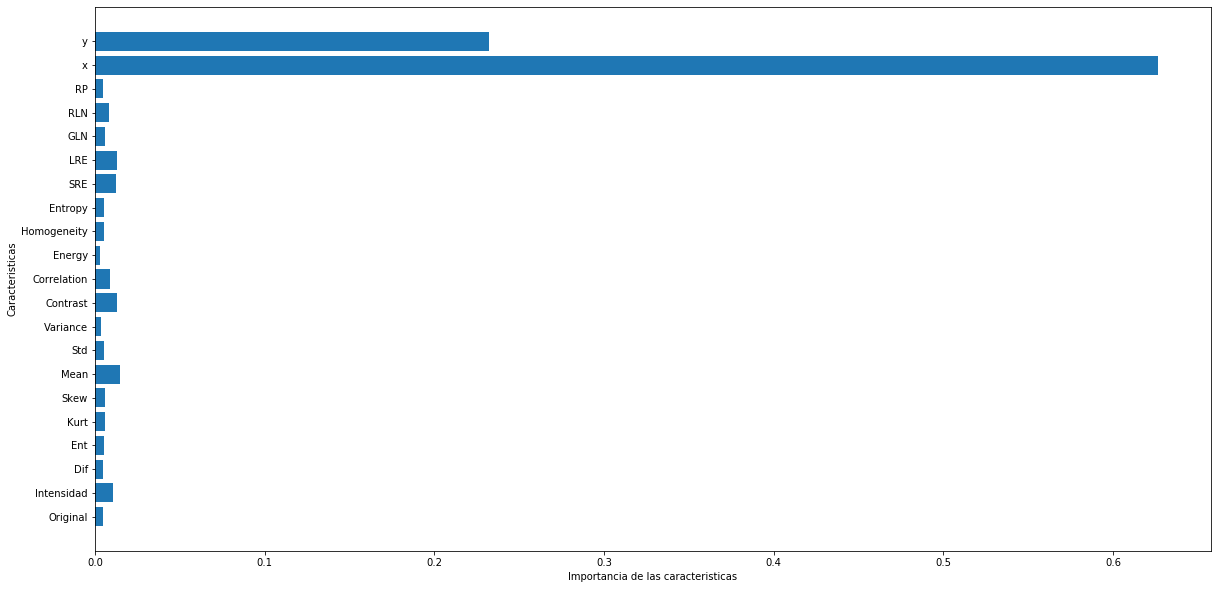

In [15]:
print ('Feature Importance:')

caract=21

fig = plt.figure(figsize=(20,10))
plt.barh(range(caract),clf.feature_importances_)

plt.xlabel('Importancia de las caracteristicas')
plt.ylabel('Caracteristicas')
plt.show()

## 4. Segmentar imágenes

Se segmmentaran las imágenes de prueba (test_idx). Para esto se creara un vector de características para cada pixel el cual contenga el valor de gris en la imagen original, preprocesad y de textura, así como su posición x,y.  PAra esto se utilizara la técnica de _flatten_ 

In [16]:
# Extract random image
n = random.randint(0,len(test_idx))

# Flatten images
img_flat = imgs[n].flatten()
intensity_flat = intensity[n].flatten()
textureDif_flat = textureDif[n].flatten()
textureEnt_flat = textureEnt[n].flatten()
textureKurt_flat = textureKurt[n].flatten()
textureSkew_flat = textureSkew[n].flatten()
textureMean_flat = textureMean[n].flatten()
textureStd_flat = textureStd[n].flatten()
textureVariance_flat = textureVariance[n].flatten()
textureContrast_flat = textureContrast[n].flatten()
textureCorrelation_flat = textureCorrelation[n].flatten()
textureEnergy_flat = textureEnergy[n].flatten()
textureHomogeneity_flat = textureHomogeneity[n].flatten()
textureEntropy_flat = textureEntropy[n].flatten()
textureSRE_flat = textureSRE[n].flatten()
textureLRE_flat = textureLRE[n].flatten()
textureGLN_flat = textureGLN[n].flatten()
textureRLN_flat = textureRLN[n].flatten()
textureRP_flat = textureRP[n].flatten()

In [17]:
#extract x and y coordinates from flatten pixels
XX,YY = np.meshgrid(np.arange(imgs[n].shape[1]),np.arange(imgs[n].shape[0]))

XX,YY = np.meshgrid(np.arange(imgs[n].shape[1]),np.arange(imgs[n].shape[0]))
XX = np.array(XX.ravel())
YY = np.array(YY.ravel())

In [18]:
#Create matrix qith all pixels characterístics
img_ch = np.vstack((img_flat, intensity_flat, 
                  textureDif_flat, textureEnt_flat, textureKurt_flat,
                  textureSkew_flat, textureMean_flat, textureStd_flat,
                  textureVariance_flat, textureContrast_flat, textureCorrelation_flat,
                  textureEnergy_flat, textureHomogeneity_flat, textureEntropy_flat,
                  textureSRE_flat, textureLRE_flat, textureGLN_flat,
                  textureRLN_flat, textureRP_flat, 
                   
                    )).T

In [19]:
import pandas as pd

print(pd.DataFrame(img_ch).head(5))
print(pd.DataFrame(img_ch).tail(5))

    0    1   2   3   4    5    6    7   8   9   ...  11   12   13  14  15  \
0   62   91  54  66  59  112  109  161  35  59  ...  34  124  105  20  64   
1   65   96  46  81  57  109  109  149  37  55  ...  35  127  102  20  64   
2   77  134  29  87  64  117  110  147  45  48  ...  45  142  100  20  63   
3   99  172  27  89  65  121  114  148  61  40  ...  59  155  100  18  67   
4  111  196  46  88  70  127  121  151  68  39  ...  66  146   92  16  73   

    16   17   18  19  20  
0  109  127  161   0   0  
1  106  125  160   1   0  
2   93  134  156   2   0  
3   92  138  154   3   0  
4  103  153  163   4   0  

[5 rows x 21 columns]
        0    1   2    3   4    5    6    7   8   9   ...  11   12  13  14  \
16379  130  237  21  115  56  104  201  120  42  36  ...  42  141  94   3   
16380  130  238  30  112  52   99  207  121  46  34  ...  45  147  86   2   
16381  120  239  60   99  48  101  210  134  49  33  ...  47  152  86   2   
16382  121  240  63   78  53  111  214  155 

In [20]:
#Use clf to predict each pixel class and probability
predicted_class = clf.predict(img_ch)
predicted_prob = clf.predict_log_proba(img_ch)

#Reshape response to image dimensions
predicted_mask = predicted_class.reshape((128,128))
predicted_prob = predicted_prob[:,0].reshape((128,128))

D:\Programas\Anaconda3\envs\Curso_IM\lib\site-packages\sklearn\ensemble\_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


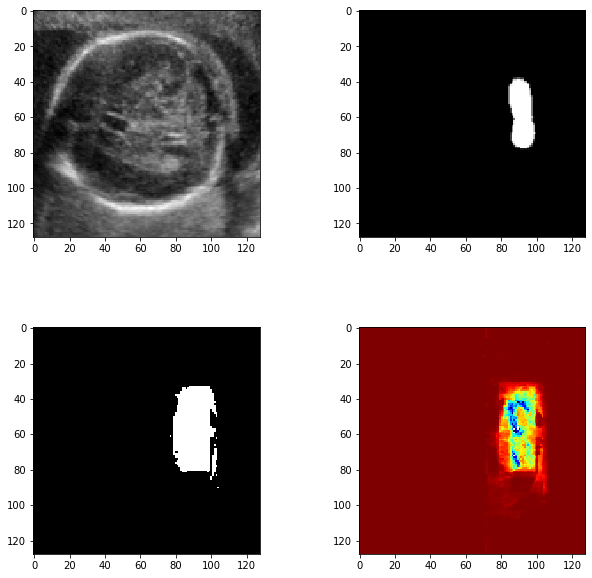

In [21]:
#Displaying image and mask
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
ax.imshow(imgs[n], cmap="gray")

ax = fig.add_subplot(2, 2, 2)
ax.imshow(masks[n], cmap="gray")

ax = fig.add_subplot(2, 2, 3)
ax.imshow(predicted_mask, cmap="gray")

ax = fig.add_subplot(2, 2, 4)
ax.imshow(predicted_prob, cmap="jet")